In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Load combined data
df_all = pd.read_csv('runs/all_runs_combined.csv', dtype={'run_id': str})
df_configs = pd.read_csv('runs/all_configs_combined.csv', dtype={'run_id': str})

# Ensure run_id is formatted with leading zeros
df_all['run_id'] = df_all['run_id'].astype(str).str.zfill(2)
df_configs['run_id'] = df_configs['run_id'].astype(str).str.zfill(2)

print("Available runs:")
print(df_configs[['run_id', 'learning_rate', 'epsilon_starting_value', 'epsilon_decay_value']].to_string(index=False))
print(f"\nUnique run_ids in data: {df_all['run_id'].unique()}")

Available runs:
run_id  learning_rate  epsilon_starting_value  epsilon_decay_value
    01         0.0001                     1.0               0.9950
    02         0.0010                     1.0               0.9950
    03         0.0100                     1.0               0.9950
    04         0.0001                     0.2               1.0000
    05         0.0001                     0.1               1.0000
    06         0.0001                     0.5               0.9950
    07         0.0001                     0.5               0.9975
    08         0.0001                     1.0               0.9950
    09         0.0001                     1.0               0.9950
    10         0.0001                     1.0               0.9950
    11         0.0001                     1.0               0.9950
    12         0.0001                     1.0               0.9950
    13         0.0001                     1.0               0.9950
    14         0.0001                     1.0 

## Select Runs to Compare

Modify the list below to select which runs you want to compare (2, 3, or 4 runs).
Each run will be displayed with a different color and label.

In [27]:
# ========== MODIFY THIS LIST TO SELECT RUNS TO COMPARE ==========
selected_runs = ['32', '33', '34']  # All available runs
# Examples:
# selected_runs = ['02', '04', '05']  # Compare epsilon strategies
# selected_runs = ['01', '02', '03', '04']  # Compare 4 runs
# =================================================================

# Define labels and markers for each run
run_labels = {
    '01': 'LR=0.0001',
    '02': 'LR=0.001',
    '03': 'LR=0.01',
    '04': 'Eps fix 0.2',
    '05': 'Eps fix 0.1',
    '06': 'Eps decay 0.5',
    '07': 'Eps decay slow 0.5',
    '08': 'Buffer 64',
    '09': 'Buffer 300000',
    '10': 'Buffer 1000',
    '11': 'Hard update high freq',
    '12': 'Hard update low freq',
    '13': 'Hard update very high freq',
    '14': 'Hard update ultra high freq',
    '15': 'Hard update mid freq',
    '16': 'Tau 0.01',
    '17': 'Tau 0.1',
    '18': 'DDQN LR=0.0001',
    '19': 'DDQN LR=0.001'
}

run_markers = {
    '01': 'o',
    '02': 's',
    '03': '^',
    '04': 'd',
    '05': 'v',
    '06': 'p',
    '07': '*',
    '08': 'h',
    '09': 'H',
    '10': 'D',
    '11': 'X',
    '12': 'P',
    '13': '+',
    '14': 'x',
    '15': '1',
    '16': '2',
    '17': '3',
    '18': '4',
    '19': '8'
}

print(f"\nComparing {len(selected_runs)} runs: {', '.join(selected_runs)}")


Comparing 3 runs: 32, 33, 34


## Training Comparison Visualization

Two plots side by side:
- **Left**: Learning curves with moving average
- **Right**: Success rate over time

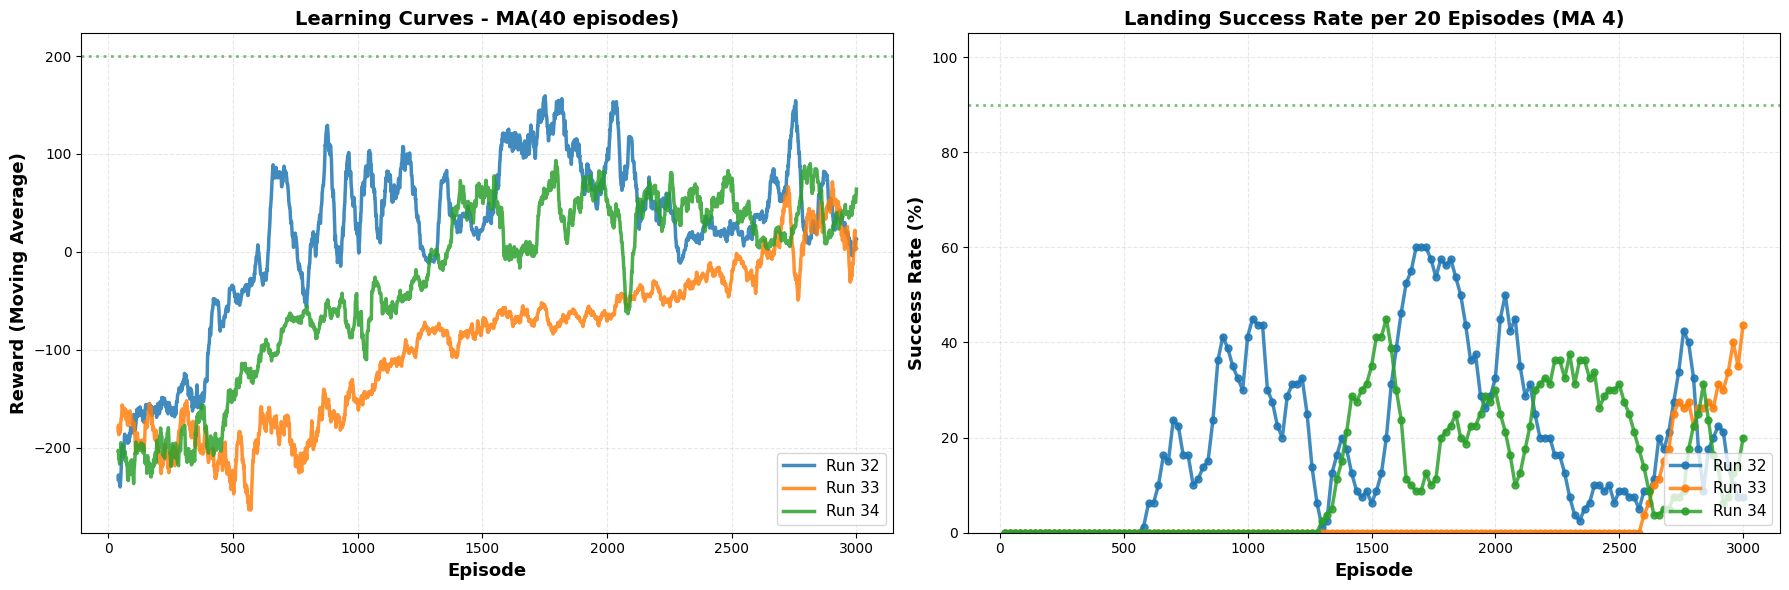

In [28]:
# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# ===== PLOT 1: Learning Curves with Moving Average =====
ax = axes[0]
window = 40

for run_id in selected_runs:
    # Filter data for this run and reset index
    run_data = df_all[df_all['run_id'] == run_id].copy().reset_index(drop=True)
    
    # Calculate moving average
    run_data['reward_ma'] = run_data['reward'].rolling(window=window).mean()
    
    # Plot (let matplotlib choose colors automatically)
    ax.plot(
        run_data['episode'], 
        run_data['reward_ma'], 
        linewidth=2.5, 
        label=run_labels.get(run_id, f'Run {run_id}'), 
        alpha=0.85
    )

ax.set_xlabel('Episode', fontsize=13, fontweight='bold')
ax.set_ylabel('Reward (Moving Average)', fontsize=13, fontweight='bold')
ax.set_title(f'Learning Curves - MA({window} episodes)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=200, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Target (200)')

# ===== PLOT 2: Success Rate =====
ax = axes[1]
log_interval = 20
ma_window = 4  # moving average over 5 intervals

for run_id in selected_runs:
    # Filter data for this run and reset index
    run_data = df_all[df_all['run_id'] == run_id].copy().reset_index(drop=True)
    
    # Calculate success rate per interval using reset index
    run_data['interval'] = run_data.index // log_interval
    success_rate = run_data.groupby('interval')['outcome'].apply(
        lambda x: (x == 'landed_success').sum() / len(x) * 100
    )
    
    # Moving average (base 5) of success rate
    success_rate_ma = success_rate.rolling(window=ma_window, min_periods=1).mean()
    
    # Episodes for x-axis (now correctly 20, 40, 60, ... 800)
    episodes_bin = (np.arange(len(success_rate)) + 1) * log_interval
    
    # Plot (let matplotlib choose colors automatically)
    ax.plot(
        episodes_bin, 
        success_rate_ma.values, 
        marker=run_markers.get(run_id, 'o'),
        linewidth=2.5, 
        label=run_labels.get(run_id, f'Run {run_id}'), 
        markersize=5,
        alpha=0.85
    )

ax.set_xlabel('Episode', fontsize=13, fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontsize=13, fontweight='bold')
ax.set_title(f'Landing Success Rate per {log_interval} Episodes (MA {ma_window})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0, 105])
ax.axhline(y=90, color='green', linestyle=':', linewidth=2, alpha=0.5, label='90% Success')

plt.tight_layout()
plt.show()

## Individual Episode Outcomes

Scatter plot showing each episode reward, colored by outcome type (success, crash, out of bounds, truncated).

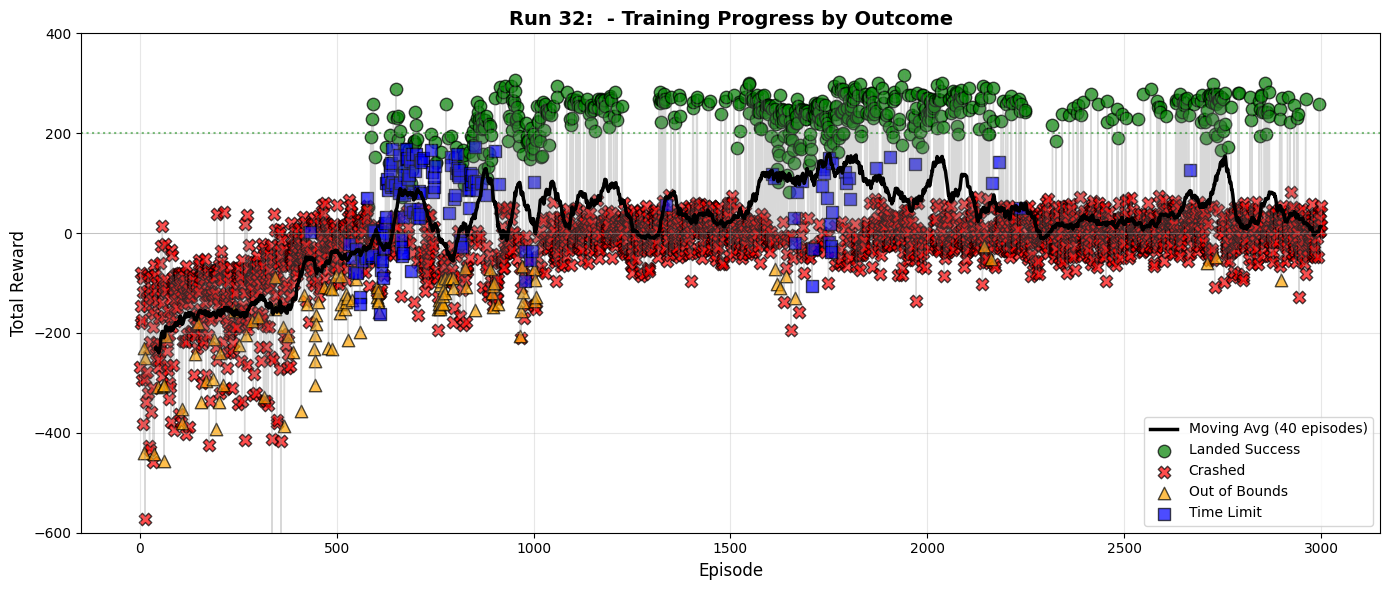


📊 Run 32 Statistics:
  Average Reward: 19.700
  Max Reward: 316.350
  Min Reward: -617.290
  Std Dev: 134.401
  Success Rate: 19.8%
------------------------------------------------------------


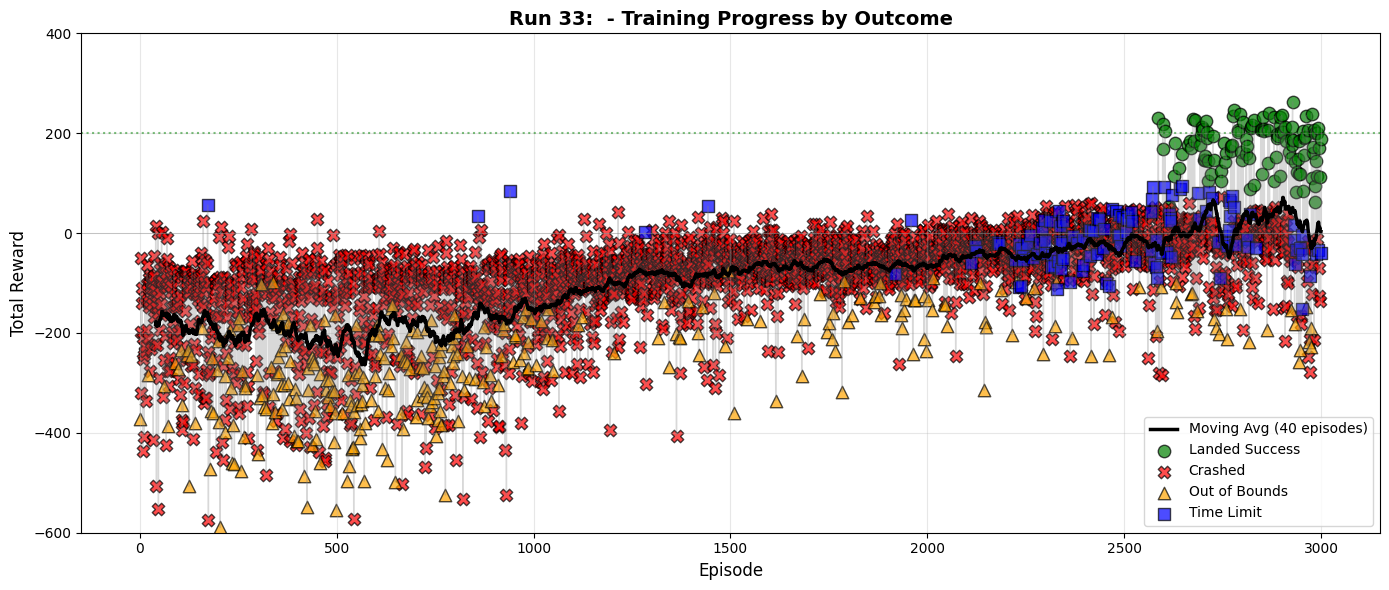


📊 Run 33 Statistics:
  Average Reward: -94.999
  Max Reward: 262.730
  Min Reward: -589.400
  Std Dev: 119.145
  Success Rate: 3.9%
------------------------------------------------------------


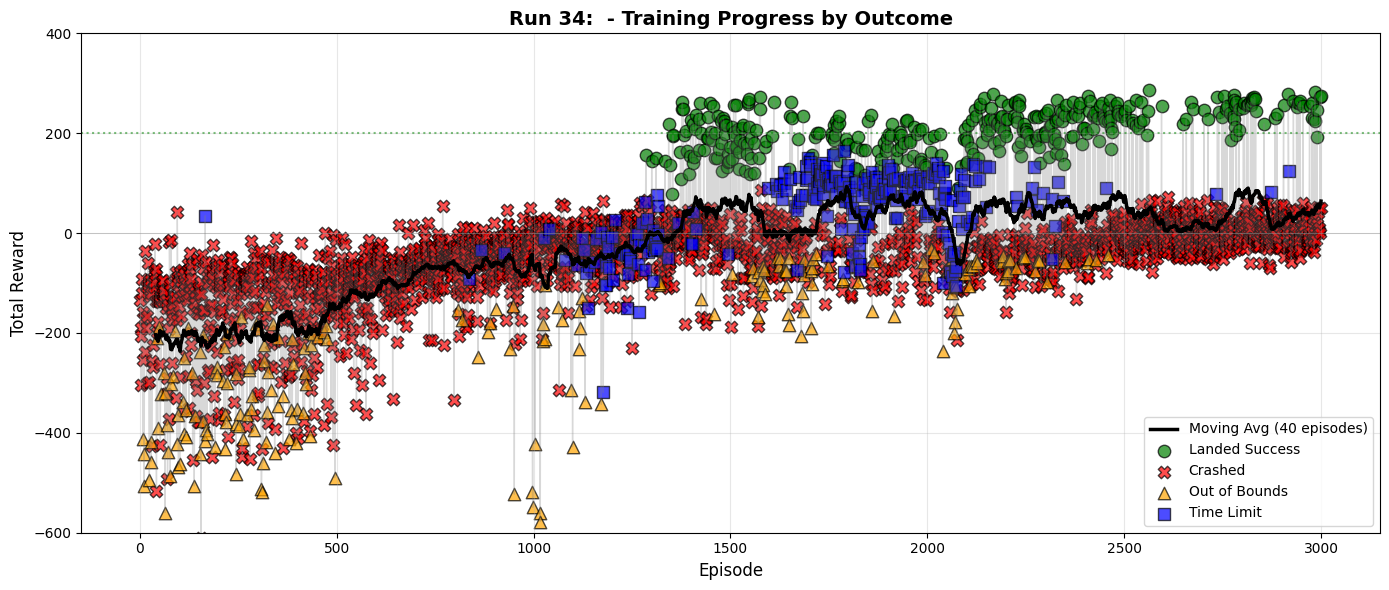


📊 Run 34 Statistics:
  Average Reward: -28.811
  Max Reward: 287.360
  Min Reward: -609.640
  Std Dev: 135.537
  Success Rate: 12.7%
------------------------------------------------------------


In [29]:
# Color and marker mapping for outcomes (same style as DQN_train)
outcome_styles = {
    'landed_success': {'color': 'green', 'marker': 'o', 'label': 'Landed Success'},
    'crashed': {'color': 'red', 'marker': 'X', 'label': 'Crashed'},
    'out_of_bounds': {'color': 'orange', 'marker': '^', 'label': 'Out of Bounds'},
    'time_limit': {'color': 'blue', 'marker': 's', 'label': 'Time Limit'}
}

# Create one figure per run (not stacked - full width each)
for run_id in selected_runs:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Filter data for this run
    run_data = df_all[df_all['run_id'] == run_id].copy().reset_index(drop=True)
    
    # Base line plot (rewards connected)
    ax.plot(run_data['episode'], run_data['reward'], alpha=0.3, linewidth=1, color='gray')
    
    # Plot moving average
    run_data['reward_ma'] = run_data['reward'].rolling(window=window).mean()
    ax.plot(run_data['episode'], run_data['reward_ma'], linewidth=2.5, 
            label=f'Moving Avg ({window} episodes)', color='black')
    
    # Plot scatter points with different markers for each outcome
    for outcome, style in outcome_styles.items():
        outcome_data = run_data[run_data['outcome'] == outcome]
        if len(outcome_data) > 0:
            ax.scatter(
                outcome_data['episode'], 
                outcome_data['reward'], 
                c=style['color'], 
                marker=style['marker'], 
                label=style['label'], 
                s=80, 
                alpha=0.7, 
                edgecolors='black', 
                linewidth=1
            )
    
    # Styling
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Total Reward', fontsize=12)
    ax.set_title(f'Run {run_id}: {run_labels.get(run_id, "")} - Training Progress by Outcome', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-600, 400])
    ax.axhline(y=200, color='green', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this run
    print(f"\n📊 Run {run_id} Statistics:")
    print(f"  Average Reward: {run_data['reward'].mean():.3f}")
    print(f"  Max Reward: {run_data['reward'].max():.3f}")
    print(f"  Min Reward: {run_data['reward'].min():.3f}")
    print(f"  Std Dev: {run_data['reward'].std():.3f}")
    print(f"  Success Rate: {(run_data['outcome'] == 'landed_success').sum() / len(run_data) * 100:.1f}%")
    print("-" * 60)

## Statistical Summary

Compare key metrics across selected runs.

In [30]:
# Calculate statistics for selected runs
stats_list = []

for run_id in selected_runs:
    run_data = df_all[df_all['run_id'] == run_id].copy()
    
    # Calculate metrics
    stats = {
        'Run': run_id,
        'Label': run_labels.get(run_id, f'Run {run_id}'),
        'Avg Reward': run_data['reward'].mean(),
        'Max Reward': run_data['reward'].max(),
        'Final 100 Avg': run_data.tail(100)['reward'].mean(),
        'Success Rate (%)': (run_data['outcome'] == 'landed_success').sum() / len(run_data) * 100,
        'Crash Rate (%)': (run_data['outcome'] == 'crashed').sum() / len(run_data) * 100
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
print("\nStatistical Comparison:")
print(stats_df.to_string(index=False))

# Find best performing run
best_run = stats_df.loc[stats_df['Final 100 Avg'].idxmax()]
print(f"\n🏆 Best performing run: {best_run['Run']} ({best_run['Label']})")
print(f"   Final 100 episodes average: {best_run['Final 100 Avg']:.2f}")
print(f"   Overall success rate: {best_run['Success Rate (%)']:.2f}%")


Statistical Comparison:
Run  Label  Avg Reward  Max Reward  Final 100 Avg  Success Rate (%)  Crash Rate (%)
 32 Run 32   19.700113      316.35        17.6275         19.833333       71.566667
 33 Run 33  -94.998830      262.73         9.9492          3.866667       81.566667
 34 Run 34  -28.810773      287.36        50.2723         12.666667       70.633333

🏆 Best performing run: 34 (Run 34)
   Final 100 episodes average: 50.27
   Overall success rate: 12.67%
